In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.rc('figure',figsize=(17,13))
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
# panel 
#!pip install panel
#jupyter serverextension enable panel.io.jupyter_server_extension

In [ ]:
df_read = pd.read_csv('Microsoft_Twitter.csv')
df_msft = df_read.copy()
df_msft

In [ ]:
df_msft.info()

In [ ]:
#pip install datatile

In [ ]:
#pip install datatile
from datatile.summary.df import DataFrameSummary

dfs = DataFrameSummary(df_msft)

In [ ]:
dfs.columns_types

In [ ]:
dfs.columns_stats

In [ ]:
dfs['favourite_count']

In [ ]:
#Check for duplicates
df_msft[df_msft.duplicated()]

In [ ]:
# convert created_at column to datetime
df_msft['created_at'] = pd.to_datetime(df_msft['created_at'])

# Tweets per Day

In [ ]:
#tweets per day
tweets_per_day = df_msft['created_at'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

In [ ]:
#plot
plt.figure(figsize=(65,15))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()


In [ ]:
#check first date, newest
df_msft.head(1)['created_at']

In [ ]:
#check last date, oldest
df_msft.tail(1)['created_at']

# Tweets per hour

In [ ]:
tweets_per_hour = df_msft['created_at'].dt.strftime('%H').value_counts().sort_index().reset_index(name='counts')

In [ ]:
#plot
plt.figure(figsize=(25,8))
ax = sns.barplot(x='index', y='counts', data=tweets_per_hour,edgecolor = 'black',ci=False, palette='mako_r')
plt.title('Tweets count by hour')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()



# Favourite tweets

In [ ]:
f_tweets = df_msft[['text','favourite_count']].sort_values('favourite_count', ascending=False)

In [ ]:
#top 10 fav tweets
f_tweets['text'].iloc[:10].values

# Retweets

In [ ]:
retweets = df_msft[['text','retweet_count']].sort_values('retweet_count', ascending=False)

In [ ]:
#top 10
retweets['text'].iloc[:10].values

# Vader Sentiment Analysis

In [ ]:
#!pip install vaderSentiment
#!pip install flair
#!pip install emoji
#!pip install textblob

In [ ]:
#!pip install vaderSentiment
#!pip install flair
#!pip install emoji

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence
from wordcloud import WordCloud, STOPWORDS
import re, string
import emoji

In [ ]:
sentiment_vader = SentimentIntensityAnalyzer()

In [ ]:
sentiments = []
for tweet in df_msft.text:
    sentiment_dict = sentiment_vader.polarity_scores(tweet)
    sentiment_dict.pop('compound', None)
    sentiments.append(max(sentiment_dict , key=sentiment_dict.get))

In [ ]:
df_msft['sentiment'] = sentiments
df_msft['sentiment'].value_counts()

# Clean up the tweet text

In [ ]:
# text cleaning functions 

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n 
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters 
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, keep those in the middle of the sentence 
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol 
    return new_tweet2

#Filter special characters 
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

def remove_spam(text):
    match = re.search(r'subscribe', text)
    if match:
        return ''
    else:
        return text

# Apply the cleaning functions to df

In [ ]:
clean_texts = []
for t in df_msft.text:
    clean_texts.append(remove_spam(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t)))))))

In [ ]:
# new column with clean_text
df_msft['clean_text'] = clean_texts

In [ ]:
# lowercase
df_msft['clean_text'] = df_msft['clean_text'].str.lower() 

# check tweet clean text

In [ ]:
text_len = []
for text in df_msft.clean_text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df_msft['text_len'] = text_len

In [ ]:
df_msft

In [ ]:
#plot cleaned text length
plt.figure(figsize=(25,8))
sns.histplot(x='text_len', data=df_msft, bins=40)
plt.title('Cleaned Text Length')
plt.show()

# too many tweet texts with few words

In [ ]:
# plot
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_msft[df_msft['text_len'] < 10], palette='mako')
plt.title('Teets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()



# Removed the tweets with fewer than 3 words

In [ ]:
df_msft_cleaned = df_msft[df_msft['text_len'] > 2]

In [ ]:
df_msft_cleaned

# Analysis of cleaned df and further processing

In [ ]:
sentiment_vader = SentimentIntensityAnalyzer()

In [ ]:
sentiments = []
for tweet in df_msft_cleaned.text:
    sentiment_dict = sentiment_vader.polarity_scores(tweet)
    sentiment_dict.pop('compound', None)
    sentiments.append(max(sentiment_dict , key=sentiment_dict.get))

In [ ]:
df_msft_cleaned['sentiment'] = sentiments
df_msft_cleaned['sentiment'].value_counts()

# Further text cleaning

In [ ]:
# cleaning functions

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n 
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters 
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags
    return new_tweet2

#Filter special characters 
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

def remove_spam(text):
    match = re.search(r'subscribe', text)
    if match:
        return ''
    else:
        return text

# Apply cleaning functions to cleaned df

In [ ]:
texts_new = []
for t in df_msft_cleaned.text:
    texts_new.append(remove_spam(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t)))))))

In [ ]:
df_msft_cleaned['text_clean'] = texts_new 

In [ ]:
# lowercase
df_msft_cleaned['text_clean'] = df_msft_cleaned['text_clean'].str.lower() 

# check double cleaned text length

In [ ]:
text_len = []
for text in df_msft_cleaned.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df_msft_cleaned['text_len'] = text_len

In [ ]:
plt.figure(figsize=(20,8))
sns.histplot(x='text_len', data=df_msft_cleaned, bins=50)
plt.title('Double Cleaned Text Length')
plt.show()

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_msft_cleaned[df_msft_cleaned['text_len'] < 10], palette='mako')
plt.title('Tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

# Vader Sentiment Analysis with double cleaned text

In [ ]:
sentiment_vader = SentimentIntensityAnalyzer()

In [ ]:
sentiments = []
for tweet in df_msft_cleaned.text:
    sentiment_dict = sentiment_vader.polarity_scores(tweet)
    sentiment_dict.pop('compound', None)
    sentiments.append(max(sentiment_dict , key=sentiment_dict.get))

In [ ]:
df_msft_cleaned['sentiment_vader'] = sentiments
df_msft_cleaned['sentiment_vader'].value_counts()

In [ ]:
df_msft_cleaned

# NLTK Sentiment Analysis

In [ ]:
sentiment_nltk = SentimentIntensityAnalyzer()

In [ ]:
sentiments_nltk = []
for tweet in df_msft_cleaned.text_clean:
    sentiment_dict = sentiment_nltk.polarity_scores(tweet)
    sentiment_dict.pop('compound', None)
    sentiments_nltk.append(max(sentiment_dict , key=sentiment_dict.get))

In [ ]:
df_msft_cleaned['sentiment_nltk'] = sentiments_nltk
df_msft_cleaned['sentiment_nltk'].value_counts()

# Flair Sentiment Analysis

In [ ]:
# this takes a long time to load, enjoy a drink
flair = TextClassifier.load('sentiment-fast');

In [ ]:
def emotion_threshold(emo, val):
    if (emo =='POSITIVE') & (val >= 0.7): #outputs 'pos' if positive confidence > 70%
        return 'pos'
    elif(emo =='NEGATIVE') & (val >= 0.7): #outputs 'neg' if negative confidence > 70%
        return 'neg'
    else:
        return 'neu' #else outputs neutral emotion

In [ ]:
sentiments_flair = []
for tweet in df_msft_cleaned.text_clean:
    sentence = Sentence(tweet)
    flair.predict(sentence)
    emo = re.findall(r"([A-Z]\w+)",str(sentence.labels))[0] #extract the emotion
    val = float(re.findall(r"([+-]?[0-9]*[.]?[0-9]+)",str(sentence.labels))[0]) #extract the confidence value for the emotion
    sentiments_flair.append(emotion_threshold(emo,val))

In [ ]:
df_msft_cleaned['sentiment_flair'] = sentiments_flair
df_msft_cleaned['sentiment_flair'].value_counts()

# Text Blob Sentiment Analysis

In [ ]:
def polarity_to_text(blob):
    if (blob.sentiment.polarity > 0.1):
        return 'pos'
    elif(blob.sentiment.polarity <= 0.1 and  blob.sentiment.polarity >= -0.05):
        return 'neu'
    else:
        return 'neg'

In [ ]:
sentiments_blob = []
for tweet in df_msft_cleaned.text_clean:
    blob = TextBlob(tweet)
    sentiments_blob.append(polarity_to_text(blob))

In [ ]:
df_msft_cleaned['sentiment_blob'] = sentiments_blob
df_msft_cleaned['sentiment_blob'].value_counts()

# Wordclouds wit positive words comparing the different Analyses 

In [ ]:
df_msft_cleaned

In [ ]:
texts_vader_pos = " ".join(sentiment for sentiment in df_msft_cleaned[df_msft_cleaned['sentiment_vader']=='pos']['text_clean'])
texts_nltk_pos = " ".join(sentiment for sentiment in df_msft_cleaned[df_msft_cleaned['sentiment_nltk']=='pos']['text_clean'])
texts_flair_pos = " ".join(sentiment for sentiment in df_msft_cleaned[df_msft_cleaned['sentiment_flair']=='pos']['text_clean'])
texts_blob_pos = " ".join(sentiment for sentiment in df_msft_cleaned[df_msft_cleaned['sentiment_blob']=='pos']['text_clean'])

In [ ]:
# vader
wordcloud_vader_pos = WordCloud(width=800,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_vader_pos)

In [ ]:
# nltk
wordcloud_nltk_pos = WordCloud(width=800,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_nltk_pos)

In [ ]:
# flair
wordcloud_flair_pos = WordCloud(width=800,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_flair_pos)

In [ ]:
# text blob
wordcloud_blob_pos = WordCloud(width=800,
                      height=400,
                      max_font_size=200,
                      max_words=50,
                      collocations=False,
                      background_color='black').generate(texts_blob_pos)

# Plot all sentiment analyses 

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
plt.suptitle('WORDCLOUD FOR POSITIVE TWEETS', fontsize=30)

ax[0,0].imshow(wordcloud_vader_pos, interpolation="bilinear")
ax[0,0].axis("off")
ax[0,0].set_title('VADER')

ax[0,1].imshow(wordcloud_nltk_pos, interpolation="bilinear")
ax[0,1].axis("off")
ax[0,1].set_title('NLTK')

ax[1,1].imshow(wordcloud_flair_pos, interpolation="bilinear")
ax[1,1].axis("off")
ax[1,1].set_title('FLAIR')

ax[1,0].imshow(wordcloud_blob_pos, interpolation="bilinear")
ax[1,0].axis("off")
ax[1,0].set_title('TEXT BLOB')

plt.tight_layout()
plt.show()

# Top 10 sentences for each sentiment analysis form

In [ ]:
# vader
df_msft_cleaned.text_clean[df_msft_cleaned['sentiment_vader']=='pos'].sample(10).values

In [ ]:
# Nltk
df_msft_cleaned.text_clean[df_msft_cleaned['sentiment_nltk']=='pos'].sample(10).values

In [ ]:
# Flair
df_msft_cleaned.text_clean[df_msft_cleaned['sentiment_flair']=='pos'].sample(10).values

In [ ]:
# text blob
df_msft_cleaned.text_clean[df_msft_cleaned['sentiment_blob']=='pos'].sample(10).values

# Tweets and Retweets Analysis

In [ ]:
# top 15
favourite_tweets = df_msft_cleaned[['text','favourite_count','sentiment_vader','sentiment_nltk','sentiment_blob','sentiment_flair']].sort_values('favourite_count', ascending=False)
favourite_tweets.iloc[:15]

In [ ]:
# top 15
retweets = df_msft_cleaned[['text','retweet_count','sentiment_vader','sentiment_nltk','sentiment_blob','sentiment_flair']].sort_values('retweet_count', ascending=False)
retweets.iloc[:15]

In [ ]:
#save cleaned df to csv
df_msft_cleaned.to_csv('Microsoft_Twitter_Cleaned.csv')

In [ ]:
df_msft_cleaned

In [ ]:
df_msft_cleaned.dtypes

In [ ]:
dfs_cleaned = DataFrameSummary(df_msft_cleaned)

In [ ]:
dfs_cleaned.columns_types

In [ ]:
dfs_cleaned.columns_stats

In [ ]:
df_msft_cleaned.columns

In [ ]:
df_msft_cleaned_final = df_msft_cleaned.drop(['Unnamed: 0','tweet_id','name','screen_name','text','mined_at','hashtags','location','source_device','retweet_text','quote_text','quote_screen_name','sentiment','clean_text'], axis = 1)

In [ ]:
df_msft_cleaned_final

In [ ]:
#save cleaned final df to csv
df_msft_cleaned_final.to_csv('Microsoft_Twitter_Cleaned_Final.csv')

In [ ]:
# convert categorical values to numerical
categorical_sentiment = df_msft_cleaned_final[['sentiment_vader','sentiment_nltk','sentiment_flair','sentiment_blob']]

In [ ]:
categorical_sentiment

In [ ]:
x = {'pos':1,'neg':-1,'neu':0}
categorical_sentiment['sentiment_vader'] = categorical_sentiment['sentiment_vader'].map(x).fillna(categorical_sentiment['sentiment_vader'])
categorical_sentiment['sentiment_nltk'] = categorical_sentiment['sentiment_nltk'].map(x).fillna(categorical_sentiment['sentiment_nltk'])
categorical_sentiment['sentiment_flair'] = categorical_sentiment['sentiment_flair'].map(x).fillna(categorical_sentiment['sentiment_flair'])
categorical_sentiment['sentiment_blob'] = categorical_sentiment['sentiment_blob'].map(x).fillna(categorical_sentiment['sentiment_blob'])

In [ ]:
categorical_sentiment.info()

In [ ]:
categorical_sentiment = categorical_sentiment.astype(int)

In [ ]:
categorical_sentiment.info()

In [ ]:
df__msft_cleaned_num = df_msft_cleaned_final[['created_at','retweet_count','favourite_count','status_count','text_len']]
df__msft_cleaned_num

In [ ]:
df__msft_cleaned_num_sentiment = pd.concat([df__msft_cleaned_num,categorical_sentiment], axis = 1, join = 'inner')

In [ ]:
df__msft_cleaned_num_sentiment.set_index('created_at')
df__msft_cleaned_num_sentiment

In [ ]:
df__msft_cleaned_num_sentiment = df__msft_cleaned_num_sentiment.drop('status_count', axis =1)

In [ ]:
df__msft_cleaned_num_sentiment

In [ ]:
#save cleaned num sentiment df to csv
df__msft_cleaned_num_sentiment.to_csv('Microsoft_Twitter_Cleaned_Num_Sentiment.csv')

# Panel

In [ ]:
# for VS code install jupiter_bokeh and enable the extension pn.extension(comms='vscode')
#!pip install jupyter_bokeh
# pn.extension(comms='vscode')

In [2]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
%matplotlib inline

In [4]:
data = pd.read_csv('MSFT_MitoExport.csv')
data['created_at'] = data.created_at.astype('datetime64[ns]')
data

,created_at,retweet_count,favourite_count,text_len,sentiment_vader,sentiment_nltk,sentiment_flair,sentiment_blob
0,2021-06-23 15:38:48,938,0,15,0,0,1,1
1,2021-06-23 16:03:00,128,1572,15,0,0,0,0
2,2021-06-23 16:42:47,22,0,18,0,0,1,0
3,2021-06-23 17:20:09,37,150,29,0,0,1,0
4,2021-06-23 17:20:09,17,116,16,0,0,1,1
...,...,...,...,...,...,...,...,...
2087,2022-02-18 00:02:37,1,11,6,1,1,1,1
2088,2022-02-18 00:03:06,0,5,5,0,0,-1,1
2089,2022-02-23 20:28:00,21,150,12,0,0,1,0
2090,2022-02-23 21:45:02,58,301,13,0,0,1,0


In [ ]:
#data = data.drop('Unnamed: 0', axis =1)

In [ ]:
#data

In [5]:
#plot function
def mpl_plot(avg, highlight):
    fig = Figure()
    FigureCanvas(fig) 
    ax = fig.add_subplot()
    avg.plot(ax=ax)
    if len(highlight): highlight.plot(style='o', ax=ax)
    return fig

In [8]:
#outlier function
import numpy as np
def find_outliers(variable='favourite_count', window=50, sigma=10, view_fn=mpl_plot):
    avg = data[variable].rolling(window=window).mean()
    residual = data[variable] - avg
    std = residual.rolling(window=window).std()
    outliers = (np.abs(residual) > std * sigma)
    return view_fn(avg, avg[outliers])

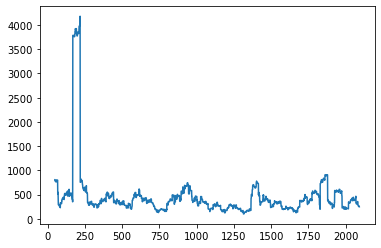

In [9]:
find_outliers(variable='favourite_count', window=50, sigma=10)

Column
    [0] Column
        [0] IntSlider(end=150, name='window', start=-50, value=50)
        [1] IntSlider(end=30, name='sigma', start=-10, value=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00101')
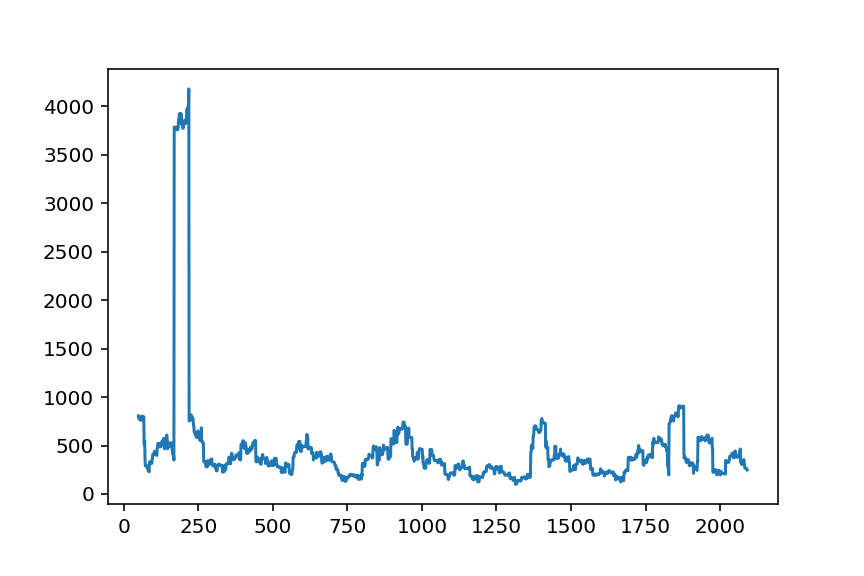

In [10]:
import panel as pn
pn.extension()

pn.interact(find_outliers)

In [11]:
kw = dict(window=(1, 60), variable=sorted(list(data.columns)), sigma=(1, 20))
i = pn.interact(find_outliers, **kw)
i.pprint()

Column
    [0] Column
        [0] Select(name='variable', options=['created_at', ...], value='favourite_count')
        [1] IntSlider(end=60, name='window', start=1, value=50)
        [2] IntSlider(end=20, name='sigma', start=1, value=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00114')


In [12]:
kw = dict(window=(1, 60), variable=sorted(list(data.columns)), sigma=(1, 20))
i = pn.interact(find_outliers, **kw)
i.pprint()

Column
    [0] Column
        [0] Select(name='variable', options=['created_at', ...], value='favourite_count')
        [1] IntSlider(end=60, name='window', start=1, value=50)
        [2] IntSlider(end=20, name='sigma', start=1, value=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00124')


Traceback (most recent call last):
 File "C:\Users\eddie\anaconda3\lib\site-packages\pandas\core\window\rolling.py", line 455, in _apply
 values = self._prep_values(b.values)
 File "C:\Users\eddie\anaconda3\lib\site-packages\pandas\core\window\rolling.py", line 266, in _prep_values
 raise NotImplementedError(
NotImplementedError: ops for Rolling for this dtype datetime64[ns] are not implemented

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
 File "C:\Users\eddie\anaconda3\lib\site-packages\pyviz_comms\__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\eddie\anaconda3\lib\site-packages\panel\viewable.py", line 273, in _on_msg
 doc.unhold()
 File "C:\Users\eddie\anaconda3\lib\site-packages\bokeh\document\document.py", line 799, in unhold
 self.callbacks.unhold()
 File "C:\Users\eddie\anaconda3\lib\site-packages\bokeh\document\callbacks.py", line 396, in unhold
 self.trigger_on_change(event)
 File "C:\Users\eddie\anaconda3\lib\site-packages\bokeh\document\callbacks.py", line 373, in trigger_on_change
 invoke_with_curdoc(doc, event.callback_invoker)
 File "C:\Users\eddie\anaconda3\lib\site-packages\bokeh\document\callbacks.py", line 408, in invoke_with_curdoc
 return f()
 File "C:\Users\eddie\anaconda3\lib\site-packages\bokeh\util\callback_manager.py", line 191, in invoke
 callback(attr, old, new)
 File "C:\Users\eddie\anaconda3\lib\site-packages\panel\reactive.py", line 302, in _comm_change
 self._process_events({attr: new})
 File "C:\Users\eddie\anaconda3\lib\site-packages\panel\reactive.py", line 263, in _process_events
 self.param.set_param(**self_events)
 File "C:\Users\eddie\anaconda3\lib\site-packages\param\parameterized.py", line 1904, in set_param
 return self_.update(kwargs)
 File "C:\Users\eddie\anaconda3\lib\site-packages\param\parameterized.py", line 1877, in update
 self_._batch_call_watchers()
 File "C:\Users\eddie\anaconda3\lib\site-packages\param\parameterized.py", line 2038, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "C:\Users\eddie\anaconda3\lib\site-packages\param\parameterized.py", line 2000, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "C:\Users\eddie\anaconda3\lib\site-packages\panel\interact.py", line 190, in update_pane
 new_object = self.object(**self.kwargs)
 File "<ipython-input-8-ce88169763e9>", line 4, in find_outliers
 avg = data[variable].rolling(window=window).mean()
 File "C:\Users\eddie\anaconda3\lib\site-packages\pandas\core\window\rolling.py", line 2019, in mean
 return super().mean(*args, **kwargs)
 File "C:\Users\eddie\anaconda3\lib\site-packages\pandas\core\window\rolling.py", line 1399, in mean
 return self._apply(window_func, center=self.center, name="mean", **kwargs)
 File "C:\Users\eddie\anaconda3\lib\site-packages\pandas\core\window\rolling.py", line 463, in _apply
 raise DataError("No numeric types to aggregate")
pandas.core.base.DataError: No numeric types to aggregate

Row
    [0] Matplotlib(Figure, name='interactive00124')
    [1] Column
        [0] Markdown(str)
        [1] Select(name='variable', options=['created_at', ...], value='favourite_count')
        [2] IntSlider(end=60, name='window', start=1, value=50)
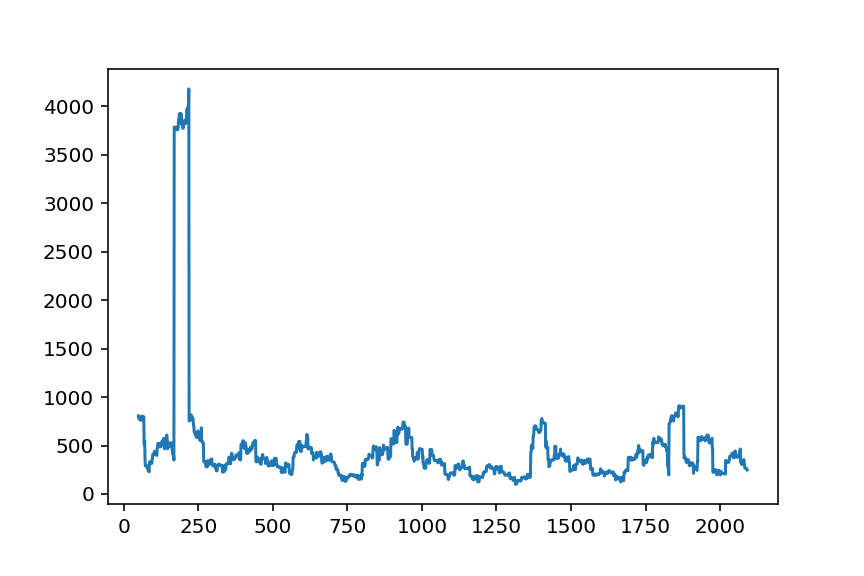

In [13]:
text = "<br>\n# Microsoft Tweets Analysis\nSelect the variable, and the time window for smoothing"

p = pn.Row(i[1][0], pn.Column(text, i[0][0], i[0][1]))
p

In [ ]:
#!pip install mitoinstaller

In [1]:
import mitosheet
mitosheet.sheet()

MitoWidget(analysis_data_json='{"analysisName": "UUID-5b0fb200-4492-4c3b-a01c-592b2fae4402", "code": {"imports…

In [ ]:
from mitosheet import *; register_analysis('UUID-27ad2213-28eb-4be6-928d-aebf48d8aee2')
    
# Imported Microsoft_Twitter_Cleaned_Num_Sentiment.csv
import pandas as pd
Microsoft_Twitter_Cleaned_Num_Sentiment = pd.read_csv(r'Microsoft_Twitter_Cleaned_Num_Sentiment.csv')

# Deleted column Unnamed: 0 from Microsoft_Twitter_Cleaned_Num_Sentiment
Microsoft_Twitter_Cleaned_Num_Sentiment.drop(['Unnamed: 0'], axis=1, inplace=True)

# Changed created_at from object to datetime
import pandas as pd
Microsoft_Twitter_Cleaned_Num_Sentiment['created_at'] = pd.to_datetime(Microsoft_Twitter_Cleaned_Num_Sentiment['created_at'], infer_datetime_format=True, errors='coerce')

# Sorted created_at in Microsoft_Twitter_Cleaned_Num_Sentiment in ascending order
Microsoft_Twitter_Cleaned_Num_Sentiment = Microsoft_Twitter_Cleaned_Num_Sentiment.sort_values(by='created_at', ascending=True, na_position='first')


# Imported Microsoft_Twitter_Cleaned_Num_Sentiment.csv
import pandas as pd
Microsoft_Twitter_Cleaned_Num_Sentiment_1 = pd.read_csv(r'Microsoft_Twitter_Cleaned_Num_Sentiment.csv')


# Drop duplicates in Microsoft_Twitter_Cleaned_Num_Sentiment
Microsoft_Twitter_Cleaned_Num_Sentiment = Microsoft_Twitter_Cleaned_Num_Sentiment.drop_duplicates(keep='first')


In [ ]:
import plotly.express as px

# Filter the dataframe so that it does not crash the browser
Microsoft_Twitter_Cleaned_Num_Sentiment_filtered = Microsoft_Twitter_Cleaned_Num_Sentiment.head(1000)

# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.histogram(Microsoft_Twitter_Cleaned_Num_Sentiment_filtered, x='text_len')
fig.update_layout(
    title='text_len (first 1000 rows) histogram',
    barmode='group',
    xaxis=dict(
        rangeslider=dict(
            visible=True,
            thickness=.05
        )
    )
)
fig.show(renderer="iframe")

In [ ]:
import plotly.express as px

# Filter the dataframe so that it does not crash the browser
Microsoft_Twitter_Cleaned_Num_Sentiment_filtered = Microsoft_Twitter_Cleaned_Num_Sentiment.head(1000)

# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.bar(Microsoft_Twitter_Cleaned_Num_Sentiment_filtered, x=['sentiment_vader', 'sentiment_nltk', 'sentiment_flair'], y='text_len')
fig.update_layout(
    title='sentiment_vader, sentiment_nltk, sentiment_flair, text_len (first 1000 rows) bar chart',
    barmode='group',
    xaxis=dict(
        rangeslider=dict(
            visible=True,
            thickness=.05
        )
    )
)
fig.show(renderer="iframe")